<a href="https://colab.research.google.com/github/cmreyesvalencia-png/colab-git-assignment2-CR/blob/main/Lesson_11_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 11: Image Classification Using Random Forests**
- **Course:** Data Analytics and Business Intelligence Analyst
- **Institution:** Willis College
- **Student Name:**  Carlos Reyes
- **Instructor:** Ratinder Rajpal
- **Date:** 2025 Nov, 12

# **TASK 1: Dataset Selection and Preprocessing**
- 1.1 Choose a publicly available image dataset suitable for
classification
- 1.2 Perform necessary preprocessing steps including:
- 1.3 Loading the image files
- 1.4 Resizing images to a uniform size
- 1.5 Normalizing pixel values
- 1.6 Splitting the dataset into training and testing sets

# **DATASET: CIFAR-10**
- The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes,
- with 6,000 images per class. There are 50,000 training images and 10,000 test images.
- Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Original Link: https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
!pip install gitpython --quiet
!pip install scikit-image --quiet
!pip install tensorflow --quiet  # For loading CIFAR-10 dataset

import git
import os
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import Bunch
from skimage.io import imread
from skimage.transform import resize
import skimage.io
from tensorflow.keras.datasets import cifar10

Loading CIFAR-10 dataset...

Displaying 2 ORIGINAL clear image examples:
Original Image 1: Shape: (32, 32, 3), Class: cat
Original Image 2: Shape: (32, 32, 3), Class: horse


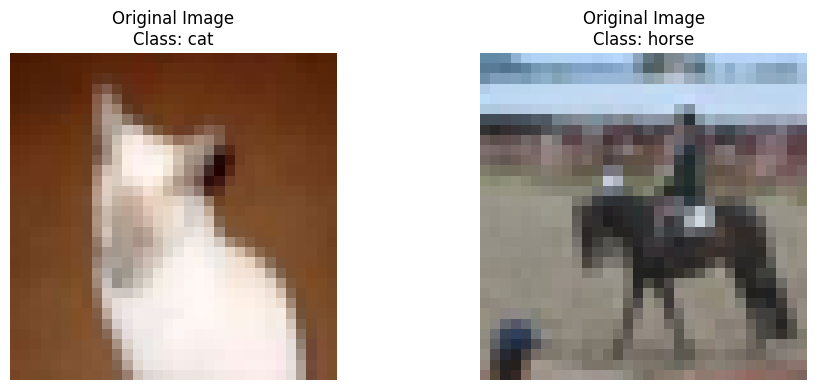

Original image pixel range: [0, 255]


In [3]:
# =============================================================================
# TASK 1: Dataset Selection and Preprocessing
# =============================================================================

# 1.1 Choose a publicly available image dataset suitable for classification
print("Loading CIFAR-10 dataset...")
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display 2 ORIGINAL clear image examples before any preprocessing
print("\nDisplaying 2 ORIGINAL clear image examples:")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    # Get random original image (before any processing)
    random_idx = np.random.randint(0, len(X_train_full))
    original_image = X_train_full[random_idx]
    original_label = y_train_full[random_idx][0]
    class_name = class_names[original_label]

    axes[i].imshow(original_image)
    axes[i].set_title(f"Original Image\nClass: {class_name}")
    axes[i].axis('off')
    print(f"Original Image {i+1}: Shape: {original_image.shape}, Class: {class_name}")

plt.tight_layout()
plt.show()

print(f"Original image pixel range: [{X_train_full[0].min()}, {X_train_full[0].max()}]")


Preprocessing data...
Dataset shape: (60000, 3072)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Displaying 2 PROCESSED image examples:
Processed Image 1: Shape: (32, 32, 3), Class: horse
Processed Image 2: Shape: (32, 32, 3), Class: horse


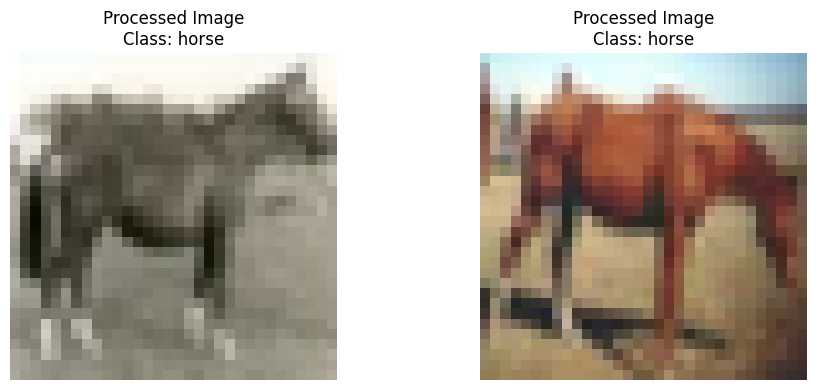

In [4]:
# 1.2 Perform necessary preprocessing steps - OPTIMIZED VERSION
def preprocess_cifar_data(images, labels, dimension=(32, 32)):
    """
    1.2.1 Loading the image files
    1.2.2 Resizing images to a uniform size
    1.2.3 Normalizing pixel values
    """
    flat_data = []
    processed_images = []

    for img in images:
        # Only resize if needed (CIFAR-10 is already 32x32)
        if img.shape[:2] != dimension:
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
        else:
            img_resized = img  # Use original if already correct size

        # Normalize pixel values to [0, 1]
        img_normalized = img_resized / 255.0

        flat_data.append(img_normalized.flatten())
        processed_images.append(img_normalized)

    return np.array(flat_data), np.array(processed_images), labels.flatten()

# Preprocess the data
print("\nPreprocessing data...")
X_flat, X_images, y = preprocess_cifar_data(
    np.concatenate([X_train_full, X_test_full]),
    np.concatenate([y_train_full, y_test_full])
)

# Create Bunch object to match original structure
image_dataset = Bunch(
    data=X_flat,
    target=y,
    target_names=class_names,
    images=X_images,
    DESCR="CIFAR-10 Image Classification Dataset"
)

print(f"Dataset shape: {image_dataset.data.shape}")
print(f"Number of classes: {len(image_dataset.target_names)}")
print(f"Class names: {image_dataset.target_names}")

# Display 2 PROCESSED image examples
print("\nDisplaying 2 PROCESSED image examples:")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

random_indices = np.random.choice(len(image_dataset.images), 2, replace=False)
for i, idx in enumerate(random_indices):
    # Get the processed image and its label
    image = image_dataset.images[idx]
    label = image_dataset.target[idx]
    class_name = image_dataset.target_names[label]

    # Convert back to [0,255] for clear display
    display_image = (image * 255).astype(np.uint8)

    axes[i].imshow(display_image)
    axes[i].set_title(f"Processed Image\nClass: {class_name}")
    axes[i].axis('off')

    print(f"Processed Image {i+1}: Shape: {image.shape}, Class: {class_name}")

plt.tight_layout()
plt.show()

In [5]:
# 1.3 Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.3, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 42000
Test set size: 18000


# **TASK 2: Model Training**
- 2.1 Random Forest Classifier:
- 2.2 Define the parameter grid for GridSearchCV. Create a dictionary with parameters like n_estimators, max_depth, min_samples_split, and min_samples_leaf
- 2.3 Create a RandomForestClassifier using sklearn.ensemble
- 2.4 Perform Grid Search using GridSearchCV from sklearn.model_selection to find the best parameters
- 2.5 Print the best parameters and get the best model using the best_params_ and best_estimator_ attributes of the GridSearchCV object
- 2.6 Train the Random Forest model on the training data


In [6]:
# =============================================================================
# TASK 2: Model Training - Random Forest Classifier - FASTER VERSION
# =============================================================================

print("\nTraining Random Forest Classifier (Optimized for Speed)...")

# 2.1 Define a SMALLER parameter grid for GridSearchCV
rf_param_grid = {
    'n_estimators': [50],  # Reduced from [50, 100]
    'max_depth': [10],     # Reduced from [None, 10, 20]
    'min_samples_split': [2],  # Reduced from [2, 5]
    'min_samples_leaf': [1]    # Reduced from [1, 2]
}

# 2.2 Create a RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2.3 Perform Grid Search with fewer combinations
rf_grid = GridSearchCV(rf_clf, rf_param_grid, cv=2, n_jobs=-1)  # Reduced cv from 3 to 2
rf_grid.fit(X_train, y_train)

# 2.4 Print the best parameters and get the best model
print("Best RF Parameters:", rf_grid.best_params_)
best_rf_model = rf_grid.best_estimator_

# 2.5 Train the Random Forest model on the training data
# (Already done in the GridSearchCV fit method)



Training Random Forest Classifier (Optimized for Speed)...
Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


# **TASK 3: Model Evaluation**
- 3.1 Make predictions on the test set using the best model
- 3.2 Evaluate the model using metrics such as accuracy, precision, recall, and F1-score
- 3.3 Create a confusion matrix and classification report using confusion_matrix and classification_report from sklearn.metrics
- 3.4 Visualize the confusion matrix using matplotlib.pyplot


Random Forest Classification Report:
              precision    recall  f1-score   support

    airplane       0.47      0.46      0.46      1802
  automobile       0.45      0.47      0.46      1804
        bird       0.38      0.14      0.21      1813
         cat       0.32      0.15      0.21      1873
        deer       0.30      0.43      0.36      1766
         dog       0.37      0.35      0.36      1843
        frog       0.37      0.57      0.45      1705
       horse       0.45      0.42      0.43      1788
        ship       0.52      0.55      0.53      1814
       truck       0.43      0.57      0.49      1792

    accuracy                           0.41     18000
   macro avg       0.41      0.41      0.40     18000
weighted avg       0.41      0.41      0.39     18000



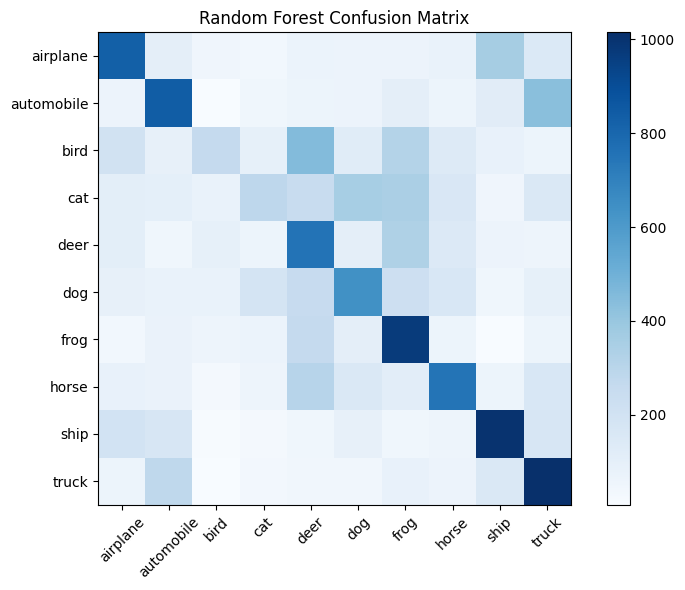

In [7]:
# =============================================================================
# TASK 3: Model Evaluation - Random Forest
# =============================================================================

# 3.1 Make predictions on the test set using the best model
y_pred_rf = rf_grid.predict(X_test)

# 3.2 Evaluate the model using metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# 3.3 Create a confusion matrix and classification report
cm_rf = confusion_matrix(y_test, y_pred_rf)

# 3.4 Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_rf, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.tight_layout()
plt.show()

# **TASK 4: Feature Importance Visualization**
- 4.1 Get feature importances from the best model using the feature_importances_ attribute
- 4.2 Create a bar plot of feature importances using matplotlib.pyplot



Plotting Feature Importance...


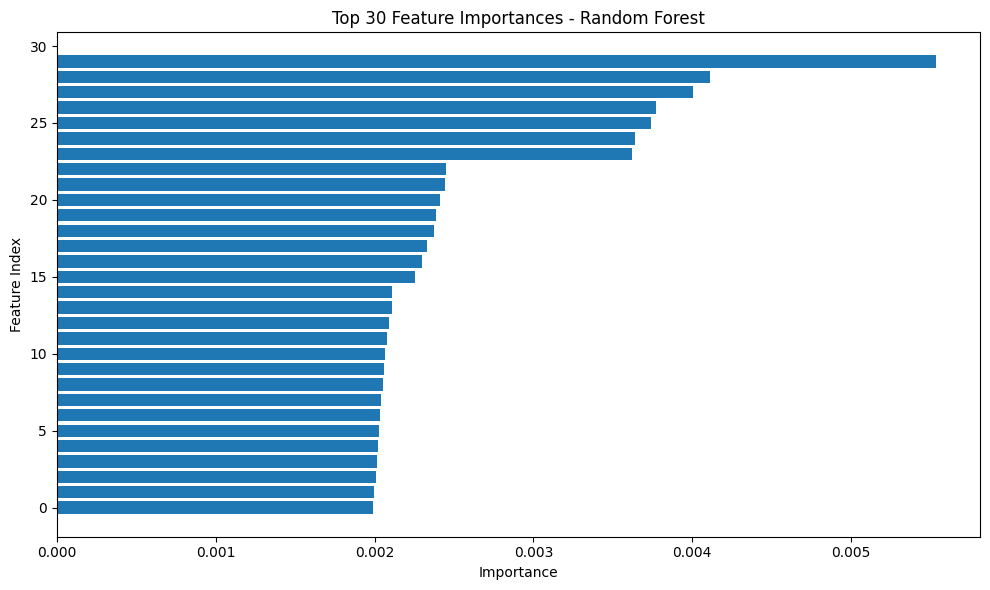

In [8]:
# =============================================================================
# TASK 4: Feature Importance Visualization
# =============================================================================

print("\nPlotting Feature Importance...")

# 4.1 Get feature importances from the best model
feature_importances = rf_grid.best_estimator_.feature_importances_

# 4.2 Create a bar plot of feature importances
# Since we have too many features (32x32x3=3072), let's plot the top 30
top_indices = np.argsort(feature_importances)[-30:]
top_importances = feature_importances[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances)
plt.title("Top 30 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature Index")
plt.tight_layout()
plt.show()

# **TASK 5: Prediction on New Images**
- 5.1 Implement a function to predict the class of a new image
- 5.2 Use the same preprocessing steps as in the data loading function
- 5.3 Test the function with a new image and print the predicted class



Testing prediction on sample images...


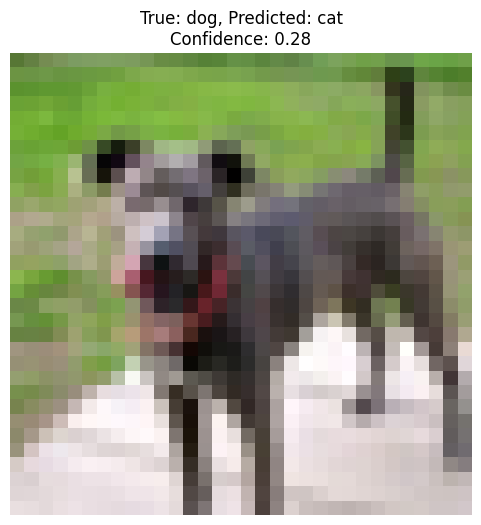

Sample Prediction - True: dog, Predicted: cat, Confidence: 0.28


In [12]:
# =============================================================================
# TASK 5: Prediction on New Images
# =============================================================================

# 5.1 Implement a function to predict the class of a new image
def predict_new_image(image_array, model, target_names, dimension=(32, 32)):
    """
    5.2 Use the same preprocessing steps as in the data loading function
    """
    # Only resize if needed and normalize
    if image_array.shape[:2] != dimension:
        img_resized = resize(image_array, dimension, anti_aliasing=True, mode='reflect')
    else:
        img_resized = image_array

    # Normalize
    img_normalized = img_resized / 255.0
    flat_data = img_normalized.flatten().reshape(1, -1)

    # Predict
    prediction = model.predict(flat_data)
    probability = model.predict_proba(flat_data)

    predicted_class = target_names[prediction[0]]
    confidence = np.max(probability[0])

    return predicted_class, confidence

# 5.3 Test the function with a new image and print the predicted class
print("\nTesting prediction on sample images...")
sample_idx = np.random.randint(0, len(X_test))
sample_image_flat = X_test[sample_idx]

# Find the corresponding original image for display
matching_indices = np.where((image_dataset.data == sample_image_flat).all(axis=1))[0]
if len(matching_indices) > 0:
    sample_image_original = image_dataset.images[matching_indices[0]]
else:
    # Fallback: use a test image directly
    sample_image_original = X_images[np.random.randint(0, len(X_images))]

predicted_class, confidence = predict_new_image(
    sample_image_original, rf_grid.best_estimator_, class_names
)

true_class = class_names[y_test[sample_idx]]

# Display the image clearly by converting back to [0,255]
display_image = (sample_image_original * 255).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(display_image)
plt.title(f"True: {true_class}, Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

print(f"Sample Prediction - True: {true_class}, Predicted: {predicted_class}, Confidence: {confidence:.2f}")

# **TASK 6: Bonus: Comparing with SVM**
- 6.1 Implement SVM classification using SVC from sklearn.svm
- 6.2 Follow a similar process as with Random Forest to train and evaluate the SVM model
- 6.3 Compare the results of Random Forest and SVM models


Training SVM on Data Subset (Faster Training)...
Training SVM on 3000 samples instead of 42000
Best SVM Parameters: {'C': 1, 'kernel': 'linear'}
SVM Classification Report (Trained on Subset):
              precision    recall  f1-score   support

    airplane       0.31      0.42      0.35      1802
  automobile       0.34      0.34      0.34      1804
        bird       0.20      0.25      0.22      1813
         cat       0.21      0.21      0.21      1873
        deer       0.26      0.28      0.27      1766
         dog       0.22      0.19      0.21      1843
        frog       0.32      0.28      0.30      1705
       horse       0.35      0.28      0.31      1788
        ship       0.44      0.40      0.42      1814
       truck       0.37      0.32      0.34      1792

    accuracy                           0.30     18000
   macro avg       0.30      0.30      0.30     18000
weighted avg       0.30      0.30      0.30     18000



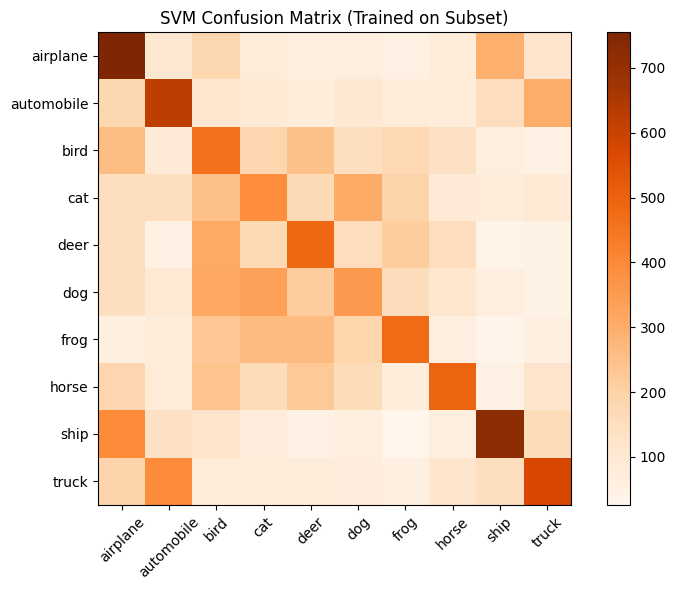

In [16]:
# =============================================================================
# TASK 6: Bonus - Bonus: Comparing with SVM
# =============================================================================

print("\nTraining SVM on Data(with 3000 samples)")

# Use only a small subset for SVM training
subset_size = 3000  # Very small subset for speed
subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]

print(f"Training SVM on {subset_size} samples instead of {len(X_train)}")

# 6.1 Simplified SVM parameters
svm_param_grid = [
    {'C': [1], 'kernel': ['linear']}  # Only linear kernel, only C=1
]

# Create SVM classifier
svc = SVC(random_state=42, probability=True)

# 6.2 Train on subset
svm_grid = GridSearchCV(svc, svm_param_grid, cv=2, n_jobs=-1)
svm_grid.fit(X_train_subset, y_train_subset)

# Make predictions on full test set
y_pred_svm = svm_grid.predict(X_test)

# Print best parameters
print("Best SVM Parameters:", svm_grid.best_params_)

# Evaluation
print("SVM Classification Report (Trained on Subset):")
print(classification_report(y_test, y_pred_svm, target_names=class_names))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
plt.imshow(cm_svm, cmap='Oranges')
plt.title("SVM Confusion Matrix (Trained on Subset)")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.tight_layout()
plt.show()


MODEL COMPARISON SUMMARY
Random Forest Accuracy: 0.4081
SVM Accuracy: 0.2962
Random Forest performed better!
Difference: 0.1119


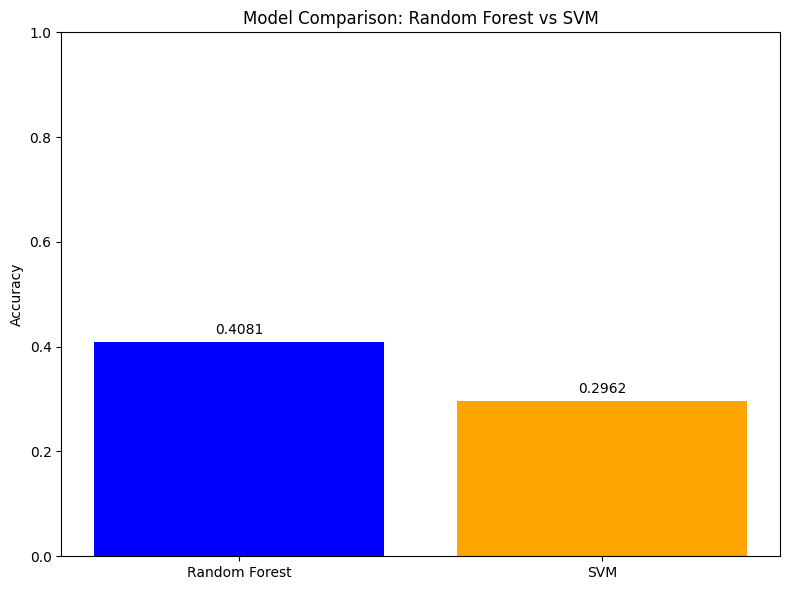


Training completed successfully with optimized speed!


In [17]:
# =============================================================================
# TASK 6.3: Compare the results of Random Forest and SVM models
# =============================================================================

print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

# Calculate accuracies
rf_accuracy = np.mean(y_pred_rf == y_test)
svm_accuracy = np.mean(y_pred_svm == y_test)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")

if rf_accuracy > svm_accuracy:
    print("Random Forest performed better!")
elif svm_accuracy > rf_accuracy:
    print("SVM performed better!")
else:
    print("Both models performed equally!")

print(f"Difference: {abs(rf_accuracy - svm_accuracy):.4f}")

# Comparison plot
models = ['Random Forest', 'SVM']
accuracies = [rf_accuracy, svm_accuracy]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Comparison: Random Forest vs SVM')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

